# Notebook for the treatment of granulometry measurements

This notebook has been conceived to treat data of granulometry measurements, on which the columns are the size intervals and the elements correspond to the population numbers (see example below). They must be in .csv format.

We start by importing the relevant libraries:

In [177]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from math import log
%matplotlib inline

plt.rcParams['font.size'] = '16'

We locate the folder of the notebook, and change (if necessary) to where the .csv file is:

In [2]:
home_cwd = os.getcwd()
home_cwd

'C:\\Users\\apeco\\Downloads\\VFO-2-APMG\\VFO-2-APMG'

We import the data, in our case the separator is ";" but it can be something else (usually ","):

If there is an error it might come from the coding of the .csv file (just change it - "Save as" in Excel to different .csv)

In [156]:
df_dis = pd.read_csv('VFO distribution_3.csv', sep=';').dropna(axis=1)
df_dis.head()

,Nom d'échantillon,time (min),Type de source d'échantillon,Numéro de lot échantillon,Nom de SOP,Nom de l'opérateur,Date et heure de la mesure,Date et heure de l'analyse,Nom particule,Indice de réfraction des particules,...,2511.886432,2884.031503,3311.311215,3801.893963,4365.158322,5011.872336,5754.399373,6606.93448,7585.77575,8709.6359
0,VFO-MG-02-120min,120,Factory,123-ABC,VFO,utilisateur,samedi 4 mars 2023 13:57:39,samedi 4 mars 2023 13:57:40,FVO,2.29,...,0,0,0,0,0,0,0,0,0,0
1,VFO-MG-02-120min,120,Factory,123-ABC,VFO,utilisateur,samedi 4 mars 2023 13:58:33,samedi 4 mars 2023 13:58:34,FVO,2.29,...,0,0,0,0,0,0,0,0,0,0
2,VFO-MG-02-120min,120,Factory,123-ABC,VFO,utilisateur,samedi 4 mars 2023 13:59:28,samedi 4 mars 2023 13:59:29,FVO,2.29,...,0,0,0,0,0,0,0,0,0,0
3,VFO-MG-02-90min,90,Factory,123-ABC,VFO,utilisateur,samedi 4 mars 2023 14:03:10,samedi 4 mars 2023 14:03:11,FVO,2.29,...,0,0,0,0,0,0,0,0,0,0
4,VFO-MG-02-90min,90,Factory,123-ABC,VFO,utilisateur,samedi 4 mars 2023 14:04:04,samedi 4 mars 2023 14:04:05,FVO,2.29,...,0,0,0,0,0,0,0,0,0,0


Please note that, apart from the raw values, we have added a 'time (min)' column for the time in minutes.

We locate the size columns among all the columns - those with just numbers. If error, it might come from comma/dot confusions.  Just change the "if" condition into: 

if column.replace(',', '.').replace('.', '').isdigit():

In [155]:
size_columns = []
for column in df_dis.columns:
    if column.replace('.', '').isdigit():
        size_columns.append(column)

We slice the dataframe to select just the time and the size columns among all the columns which are not useful:

In [157]:
df_filtered = df_dis[['time (min)'] + size_columns].astype('float')
df_filtered.head()

,time (min),0.01,0.01148154,0.01318257,0.01513561,0.01737801,0.01995262,0.02290868,0.02630268,0.03019952,...,2511.886432,2884.031503,3311.311215,3801.893963,4365.158322,5011.872336,5754.399373,6606.93448,7585.77575,8709.6359
0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We get the sizes:

In [160]:
df_sizes =  df_dis[size_columns].astype('float')
sizes = list(df_sizes.columns.astype('float'))
print('First five limits of size intervals: ', sizes[:5])

First five limits of size intervals:  [0.01, 0.01148154, 0.01318257, 0.01513561, 0.01737801]


We define a function to represent the distribution of the given time:

In [168]:
def represent(df_filtered, time):
    """
    Introduce a time and the filtered dataframe, it plots all the measurements at that given time.
    
    Input: dataframe and time.
    Output: None
    Display: subplots of distributions.
    """
    fig, ax = plt.subplots(ncols=len(df_filtered[df_filtered['time (min)'] == time].index), figsize=(12,4), sharey=True, sharex=True)

    for i, index in enumerate(df_filtered[df_filtered['time (min)'] == time].index):
        ax[i].bar(sizes, df_sizes.loc[index].values, align='edge', edgecolor='black', linewidth=0.1, alpha=0.7)
        ax[i].set_yscale('log')
        ax[i].set_xscale('log')
        
    ax[0].set_ylabel('population')
    ax[1].set_xlabel('particle size (um)')

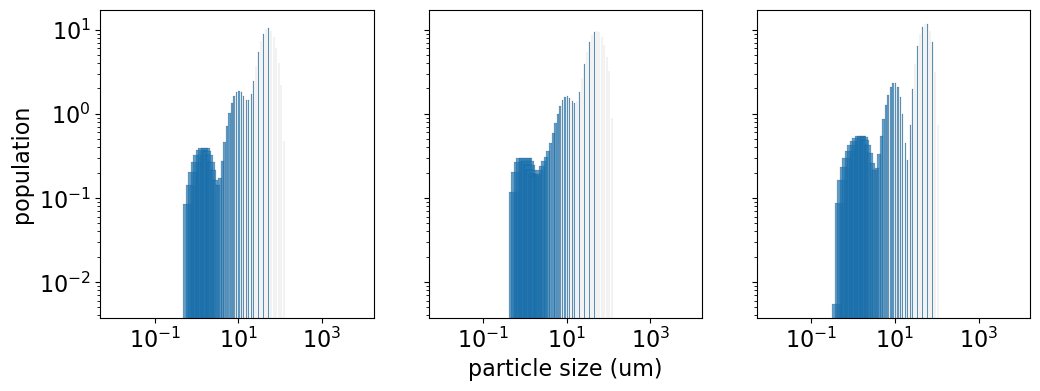

In [169]:
represent(df_filtered, 0)

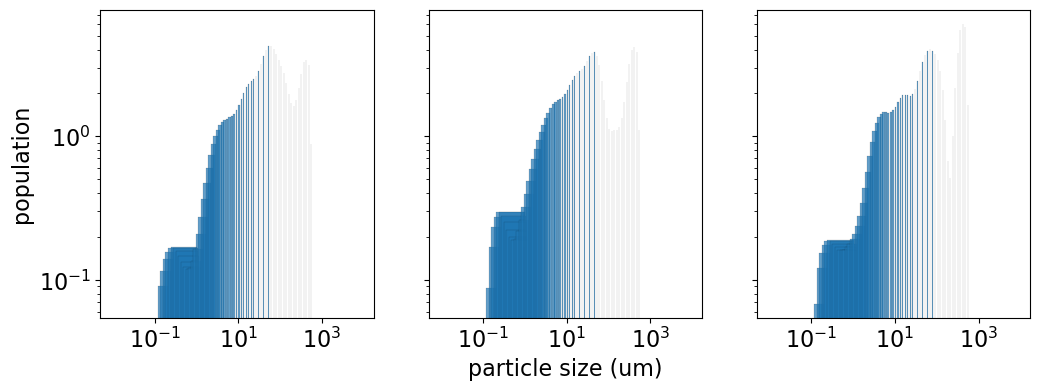

In [170]:
represent(df_filtered, 15)

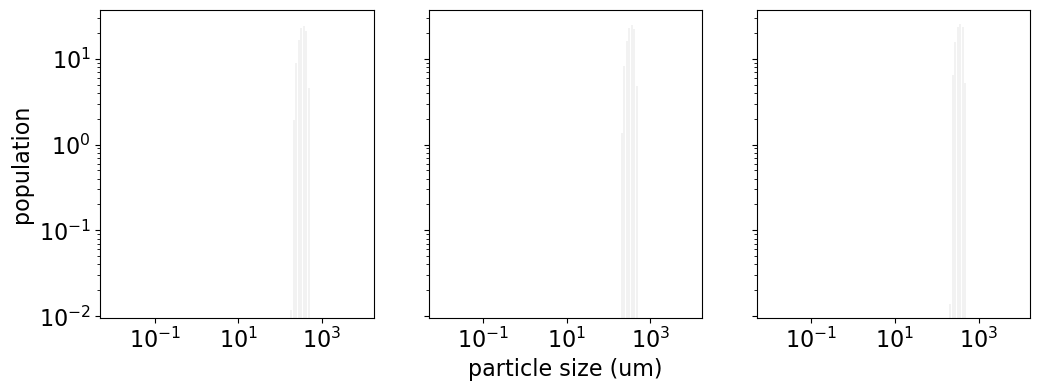

In [171]:
represent(df_filtered, 30)

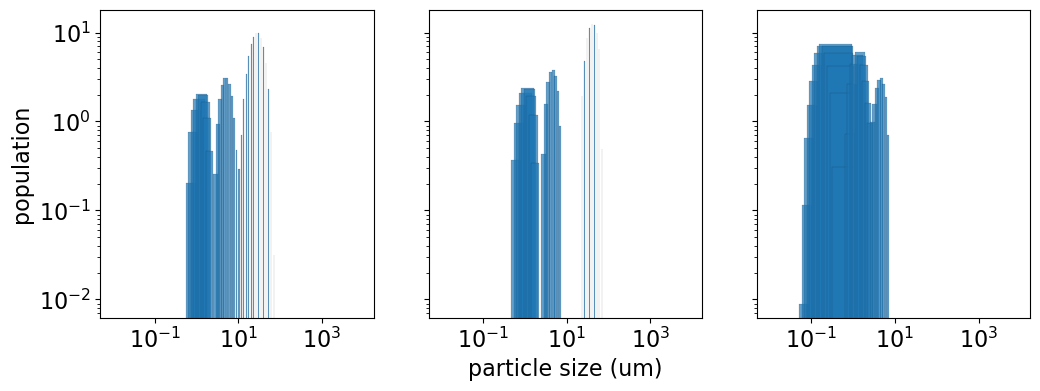

In [166]:
represent(90)

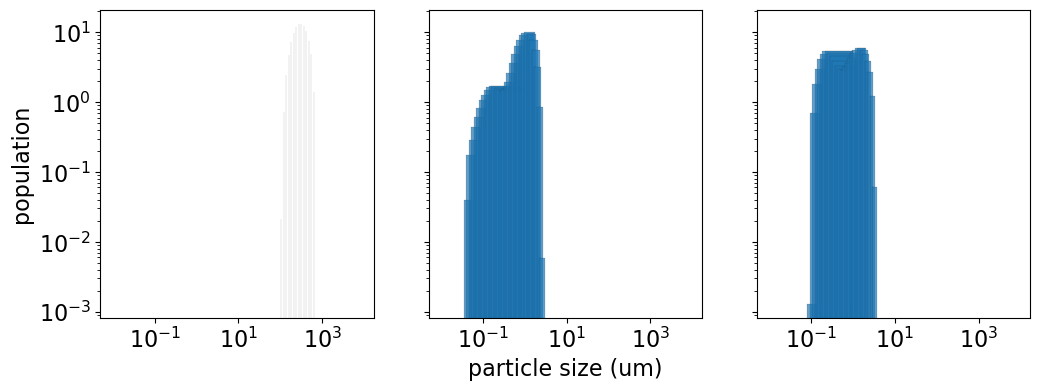

In [172]:
represent(df_filtered, 120)

In our case, the last time has a bad solvent choice:

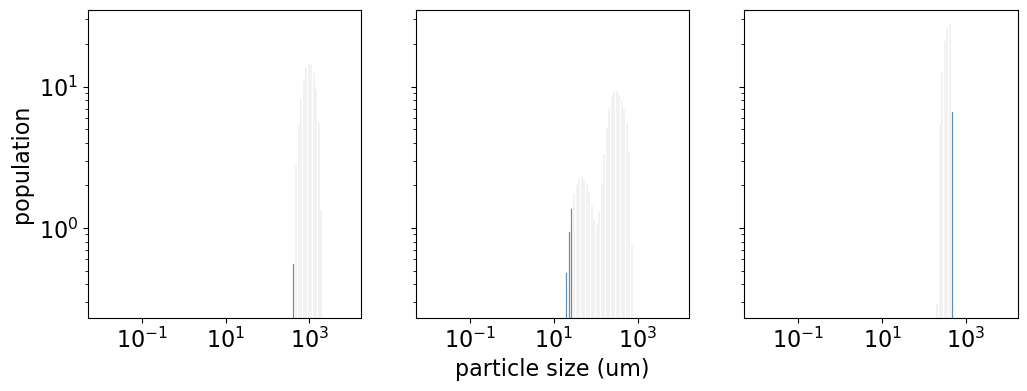

In [173]:
represent(df_filtered, 150)

## Representation for different times:

We define a function to get the population distributon line as a function of the particle size:

In [96]:
def get_line(df, time):
    """
    Introduce a time, it finds slice of the dataframe which respects that time. Means the population values.
    
    Input: time, dataframe to find the values.
    Output: dataframe with population vs. size. The size is calculated as geometric mean of interval borders.
    """
    
    t = df.groupby('time (min)').mean() # group by times
    sizes_intervals = list(map(lambda x: float(x), t.columns)) + [1e4] # we complete values with last value
    
    sizes = pd.Series([(sizes_intervals[i]*sizes_intervals[i+1])**0.5 for i in range(len(sizes_intervals) - 1)])
    return pd.concat([sizes, pd.Series(t.loc[time].values)], axis=1, keys=('size', 'pop'))

We create an offset to move the representations up:

In [148]:
offset = 5

[]

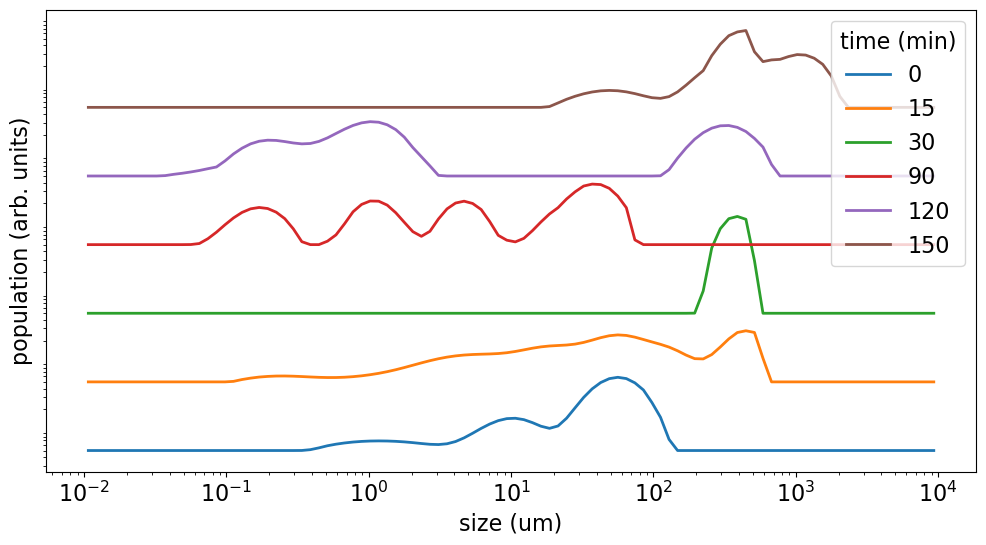

In [223]:
fig, axs = plt.subplots(1, 1, figsize=(12,6))
plt.rcParams['font.size'] = '16'

for i, time in enumerate(df_filtered.sort_values('time (min)')['time (min)'].unique()):
    f = get_line(df_filtered, time)
    f['popoff'] = f['pop'] * (10**(i+1))*offset + (10**(i+1))*offset
    sns.lineplot(x='size', y='popoff', data=f, ax=axs, label=int(time), palette='bright', lw=2)
plt.legend(title = 'time (min)')
plt.yscale('log')
plt.xscale('log')
    
axs.set_xlabel('size (um)')
axs.set_ylabel('population (arb. units)')
axs.set_yticks([])

Same but filling the areas:

[]

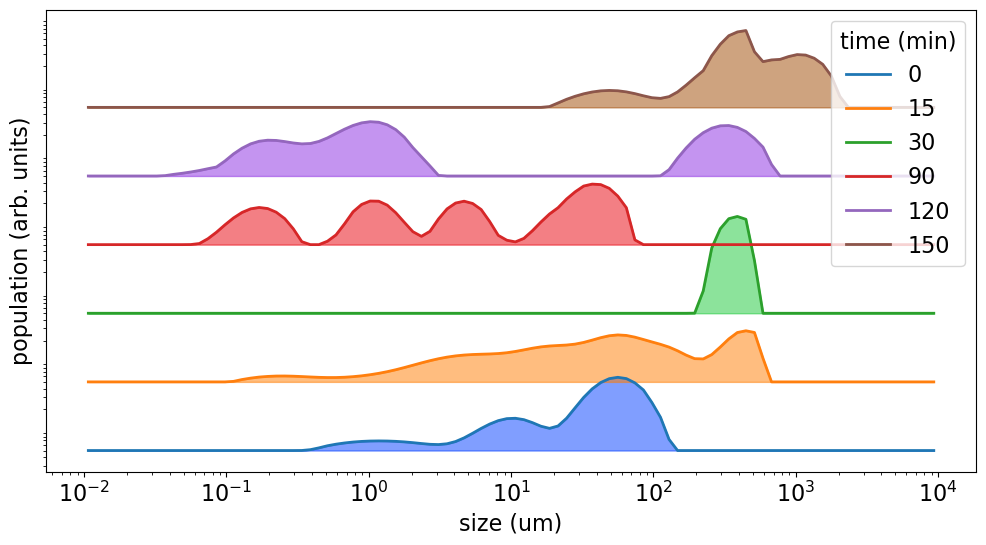

In [222]:
fig, axs = plt.subplots(1, 1, figsize=(12,6))
plt.rcParams['font.size'] = '16'

for i, time in enumerate(df_filtered.sort_values('time (min)')['time (min)'].unique()):
    f = get_line(df_filtered, time)
    f['popoff'] = f['pop'] * (10**(i+1))*offset + (10**(i+1))*offset
    sns.lineplot(x='size', y='popoff', data=f, ax=axs, label=int(time), palette='bright', lw=2)
    axs.fill_between(f['size'], f['popoff'], f['popoff'].min(), color=sns.color_palette('bright').as_hex()[i], alpha=.5, )
plt.legend(title = 'time (min)')
plt.yscale('log')
plt.xscale('log')
    
axs.set_xlabel('size (um)')
axs.set_ylabel('population (arb. units)')
axs.set_yticks([])